In [14]:
## Import Statements
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib
import scipy.fftpack
import scipy.io
from scipy import ndimage
import dill
import scipy.optimize.nnls as nnls
import sklearn
import scipy.cluster.vq as spc
from matplotlib import cm
import cvxpy as cp
import copy
import multiprocessing as mp
from joblib import Parallel, delayed
from tqdm import tqdm

In [15]:
## For saving notebook state
#dill.dump_session('ConvAnalysis.db')

#dill.load_session('ConvAnalysis.db')


To-Do:
 1) Finish SSIM Implementation
 2) Design & Implement Metric Class 
     - each metric is a clas with subsequent function
     - implement error handling
     - expand to API to run greedy simulations 

Dependent Variables of Interest when Varying Perceptual Error Metrics: 


    1) Convergence Speed (number of stimulations vs error of a particular metric) 
    2) Total Current for a Given Reconstruction
    3) Vector Angle between reconstructed images
    4) Error Signal in Pixel Intensity & Frequency Domains
    5) Electrode Activity  
    6) Clustering of Error Metrics in PCA Space
    7) Histogram of Stimulation Frequency  versus number of cells stimulated 
    


In [16]:
## Simulation Functions
def metricCompar(imgData,simParams,psychParams, electrode):
    # Compare Error Metrics Side-by-Side for the same set of images    
    
    imgSet = imgData.imgSet
    xs     = imgData.xs
    ys     = imgData.ys
    
    if electrode:
        print('Solving for Electrode Activities...')
    else:
        print('Solving for Cellular Activities...')    
    
    print('MSE Activity Reconsruction:')
    mseImgs, mseActs = reconsImgSet(imgSet,simParams, psychParams, "mse", electrode=False)
    print('wMSE Activity Reconstruction')
    wmsImgs, wmsActs = reconsImgSet(imgSet,simParams, psychParams, "wms", electrode=False)
    print('SSIM Activity Reconstruction')
    ssmImgs, ssmActs = reconsImgSet(imgSet,simParams, psychParams, "ssm", electrode=False)
    
    print('Activities Solved. Rebuilding Images ...')
    pixelDims = simParams["pixelDims"]
    
    mseRecons = rebuildImg(img,mseImgs,xs,ys,pixelDims,psychParams)
    wmsRecons = rebuildImg(img,wmsImgs,xs,ys,pixelDims,psychParams)
    ssmRecons = rebuildImg(img,ssmImgs,xs,ys,pixelDims,psychParams)

    print('Images rebuilt.')
    print('Simulation Complete')
    
    return (
            mseImgs, wmsImgs, ssmImgs,
            mseActs, wmsActs, ssmActs,
            mseRecons, wmsRecons, ssmRecons
           )

def reconsImgSet(imgSet, simParams, psychParams, metric, electrode):
    # Given a set of images (imgSet) as a 2d Matrix, and a metric, reconstruct
    # the image set according to the given image in parallel according to the available cpu cores    
    if electrode:
        activityLength = simParams["P"].shape[1]
    else:
        activityLength = simParams["A"].shape[1]
    
    numPixels = imgSet.shape[0]
    numImgs   = imgSet.shape[1]
    
    # convert imgSet to list for parallelization
    imgList = []
    for i in np.arange(numImgs):
        imgList.append(imgSet[:,i])
     
    num_cores = mp.cpu_count()
    
    # run reconstructions in parallel
    results = np.asarray(Parallel(n_jobs=num_cores)(delayed(actSolver)(i,simParams,psychParams,metric,electrode) for i in tqdm(imgList)))

    #convert results back to 2 variables separating activity and the reconstructed image
    imgs = np.zeros((numPixels,numImgs))
    acts = np.zeros((activityLength,numImgs))
    for i in np.arange(numImgs):
        imgs[:,i] = results[i,0]
        acts[:,i] = results[i,1]
    return imgs, acts   
    
def dct2(a):
    # 2D Discrete Cosine Transform and Its Inverse
    lDim = a.shape[0]
    rDim = a.shape[1]
    # build the matrix
    n, k = np.ogrid[1:2*lDim+1:2, :lDim]
    m, l = np.ogrid[1:2*rDim+1:2, :rDim]
    Dl = 2 * np.cos(np.pi/(2*lDim) * n * k)
    Dr = 2 * np.cos(np.pi/(2*rDim) * m * l)
    return (Dl.T @ a @ Dr)

def idct2(a):
    return scipy.fftpack.idct( scipy.fftpack.idct( a, axis=0 , norm='ortho'), axis=1 , norm='ortho')

def genStixel( height, width, s ):
# % genStiheightelImg: Generate a zero-mean white-noise stixelated image of specified
# % dimension.
# %   This function generates an image of size specified bwidth (height,
# %   width), and divides the image into s height s squares
# %   each stiheightel having the same Gaussian Generated white noise value. 
# %   The Gaussian values range from [-0.5, 0.5]. 


    heightStixel = np.floor(height/s).astype(int)  #% full number of stixels
    widthStixel = np.floor(width/s).astype(int)
    remWidth = width - s*widthStixel #% remainder that specifies padding
    remHeight = height - s*heightStixel

    #% Depending whether there is remainder after full stixels, determine
    #% if we need to pad. Otherwise, set pad variables to 0
    if ( remWidth != 0): 
        wpad = 1
    else: 
        wpad = 0

    if (remHeight != 0):
        hpad = 1
    else: 
        hpad = 0


    # pad the image to fit to remainder size
    img = np.zeros((height+remHeight,width+remWidth)) # %initialize image

    #% Fill in the full stixel 
    for i in np.arange(heightStixel+hpad+1):   # For each stixel block
        for j in np.arange(widthStixel+wpad+1):
            #% Generate a Gaussian White Noise value between [-0.5,0.5]
            val = np.random.normal(0,1)
            # Assign Block the Gaussian Value
            img[(i-1)*s:i*s,(j-1)*s:j*s] = val


    # clip image to original dimensions
    img = img[0:height,0:width]
    #normalize img to lie on interval [-0.5,0.5]
    if (np.max(img)) != 0:
        img = img / (2*np.max(img))
        img[img > 0] = .5
        img[img <= 0 ] = -.5
    return img

def flatDCT(pixelDims):
    # build and return a flattened dct matrix specifically for (80,40) images flattened with fortran ordering
    # Build 80 x 40 2D DCT-II Matrix
    numPixels = pixelDims[0]*pixelDims[1]
    D1 = np.zeros((numPixels,numPixels))
    D2 = np.zeros((numPixels,numPixels))
    # build a flattened form of a  1d DCT matrix 
    lDim = pixelDims[0]
    rDim = pixelDims[1]
    n, k = np.ogrid[1:2*lDim+1:2, :lDim]
    m, l = np.ogrid[1:2*rDim+1:2, :rDim]
    Dl = 2 * np.cos(np.pi/(2*lDim) * n * k)
    Dr = 2 * np.cos(np.pi/(2*rDim) * m * l)

#     imRows = 80
#     imCols = 40
    # build D1
    for i in np.arange(lDim):
        for j in np.arange(rDim):
            D1[j*lDim + i,j*lDim:(j+1)*lDim] = Dl.T[i,:]


    # build D2
    for i in np.arange(rDim):
        for k in np.arange(lDim):
            for j in np.arange(rDim):
                D2[k+j*pixelDims[0],i*pixelDims[0]+k] = Dr[i,j]
    D = D2@D1
    return D

def flatW(psychParams,pixelDims): 
    # build and return a flattned W matrix for images (img) flattned with fortran ordering
    Wp = csf(psychParams,pixelDims)
    flatW = np.reshape(Wp,(pixelDims[0]*pixelDims[1],),order='F')
    W = np.diag(flatW)
    return W

def csf(psychParams,pixelDims):
    # given a peak sensitivity frequency pf, and a psychophysically determined pixels-per-degree of viusal field ppd,
    # and and image, return a mask that has the same shape as the image and applies a weighting to each pixel in the image
    # according to the contrast sensitivity function 
    def getNg(psychParams):
        e = psychParams["e"]
        Ng0 = psychParams["Ng0"]
        eg = psychParams["eg"]
        term1 = .85 / (1 + (e/.45)**2)
        term2 = .15 / (1 + (3/eg)**2)
        return Ng0*term1*term2
    
    def Mopt(f,psychParams):
        #given a spatial frequency f and psychophysical parameters,
        # return the frequnecy filetered by the optical transfer function
        # of the retina
        sigma00 = .30           # Non-retinal optical linespread constant (arcmin)
        sigmaRet = 1 / np.sqrt(7.2*np.sqrt(3)*getNg(psychParams))
        sigma_0 = np.sqrt(sigma00**2 + sigmaRet**2) # (arcmin) std deviation of linespread (function of eccentricity)
        Cab = .08    # (arcmin / mm ) dimensionality constant
        d = psychParams["d"] # pupil size in mm
        sigma = np.sqrt(sigma_0**2 + (Cab*d)**2)
        return np.exp(-2*(np.pi**2)*((sigma/60)**2)*(f**2))
        
    def intTerm(f,psychParams):
        # given spatial frequency f and psychophysical paratmeters,
        # calculate the visual-angle integration term of the CSF
        e = psychParams["e"]
        Xmax = 12   # (degrees) maximum visual integration area  
        term1 = .85 / (1 + (e/4)**2)
        term2 = .15 / (1 + (e/12)**2)
        Xmax=Xmax*(term1+term2)**-.5
        Ymax = Xmax
        Nmax = 15  # (cycles) maximum number of cycles function of eccentriicty
        XO = psychParams["XO"]
        YO = psychParams["YO"]
        
        term1 = (.5*XO)**2 + 4*e**2
        term2 = (.5*XO)**2 + e**2
        NmaxFac = term1/term2
        
        return 1/(XO*YO) + 1/(Xmax*Ymax) + NmaxFac*(f/Nmax)**2
    
    def illumTerm(psychParams):
        #given spatial frequency f and psychophysical parameters,
        # calculate the  illumance term of the CSF
        n = .03  #quantum efficiency term (function of eccentricity)
        e = psychParams["e"]
        term1 = .4 / (1 + (e/7)**2)
        term2 = .48 / (1 + (e/20)**2) 
        n = n*(term1 + term2 +.12)
        p = 1.24 # photon conversion factor (function of incident light)
        d = psychParams["d"]
        L = psychParams["L"]
        E = np.pi/4 * d**2 * L * (1 - (d/9.7)**2 + (d/12.4)**4)
        return 1/(n*p*E)
        
    def inhibTerm(f,psychParams):
        # given spatial frequency f and psychophysical parameters,
        # calculate the lateral inhibition term of the CSF
        Ng0 = psychParams["Ng0"]
        e = psychParams["e"]
        u0 = 7  #(cycles/deg) stop frequency of lateral inhibition
        term1 = .85 / (1 + (e/4)**2)
        term2 = .13 / (1 + (e/20)**2)
        u0 = u0 * (getNg(psychParams)/Ng0)**.5 * (term1 + term2 + .02)**-.5
        return 1 - np.exp(-(f/u0)**2)
    
        
    k  = psychParams["k"]
    X0 = psychParams["elecXO"]
    Y0 = psychParams["elecYO"]
    T  = psychParams["T"]
    Ng = getNg(psychParams)
    Ng0 = psychParams["Ng0"]
    ph0= 3*10**-8*Ng0/Ng  # neural noise term (sec / deg^2)
    sfRes = 1/pixelDims[0] #spatial frequency resolution is set by the number of horizontal pixels in the image 
    fxx,fyy = np.meshgrid(np.arange(pixelDims[1]),np.arange(pixelDims[0]))
    ppd = pixelDims[0]/X0
    fs = (sfRes * ppd *(fxx**2+fyy**2)**.5  )
    

    num   = Mopt(fs,psychParams) / k
    
    if not psychParams["binocular"]:
        num = num /  np.sqrt(2)
    
    denom = np.sqrt( 
        (2/T)
        *intTerm(fs,psychParams)
        *(illumTerm(psychParams) + ph0 / inhibTerm(fs,psychParams)) 
    )
    W = np.divide(num,denom)
    return W

def pruneDict(P,eActs,threshold=.01):
    # Given a dictionary and a threshol value, remove any dictionary elements whose maximum value is 
    # below the threshold.  Append an element of zeros to the pruned dictionary. 
    pp = P.copy()
    pp[pp <= threshold] = 0
    
    dictLength = pp.shape[1]
    toDel = []
    for i in  np.arange(dictLength):
        if ~np.any(pp[:,i]):
            toDel.append(i)
    
    
    pp = np.delete(pp,toDel,axis=1)
    eActs = np.delete(eActs,toDel,axis=0)
    
    return np.hstack((pp,np.zeros((pp.shape[0],1)))),  np.vstack((eActs,np.asarray(np.zeros((1,eActs.shape[1])))))
    
def mse(A,B):
    return np.linalg.norm(A-B)**2 / A.size

def jpge(A,B,psychParams,pixelDims):
    diffImg = A - B
    if diffImg.ndim is not 1: #flatten image if not already flattened
        diffImg = diffImg.flatten
    W = flatW(psychParams, pixelDims)
    W = W/np.max(W)
    D = flatDCT(pixelDims)

    return np.linalg.norm(W@D@diffImg)**2 / A.size

def SSIM(X, Y, K1=.01, K2=.03, alpha=1, beta=1, gamma=1, L=1 ):
    # Given two images A & B of the same size, calculate & Return Their Structural Similarity Index
    # Parameters: A,B: two MN x 1 flattened images
    #             K1,K2: Stability Constants (retried from Wang SSIM Paper)
    #             alpha, beta, gamma: relative powers of luminance, contrast, and structural functions respectivtely
    #             L: dynamic range of pixel intensities
    
    if X.ndim is not 1:
        X = X.flatten
        Y = Y.flatten
    
    C1 = (K1*L)**2
    C2 = (K2*L)**2
    C3 = C2/2 #by default from Wang Paper
    numPixels = X.shape[0]
    meanX = np.mean(X)
    meanY = np.mean(Y)
    lum = (2*meanX*meanY + C1) / (meanX**2 + meanY**2 + C1)

    stdX = np.std(X)
    stdY = np.std(Y)

    con = ( 2*stdX*stdY + C2) / (stdX**2 + stdY**2 + C2)
    stdXY = (1 / (numPixels-1)) * np.sum( np.multiply((X-meanX),(Y - meanY)) ) 

    srt   = (stdXY + C3) / (stdX*stdY + C3)
    ssim = lum**alpha * con**beta * srt**gamma
    return ssim

def getElecAngs(smps,stixelSize, eyeDiam, pixelDims):
    # Given a set of psychophysical parameters,the reconstructing electrode array
    # smps: stimulus monitor pixel size: the size of a single monitor pixel in lab setup on the retina (microns)
    # stixelSize:  the stixel size,which is the square root of the number of monitor pixels grouped together 
    #      to form a single STA pixel (one STA pixel is stixelSize x stixelSize monitor pixels)
    # eyeDiam: the Emmetropia diameter of the eye in milimeters
        
    
    retArea  = ( # Retinal area in milimeters
        pixelDims[0]*smps*stixelSize/1000,
        pixelDims[1]*smps*stixelSize/1000
    )
    
    elecVisAng = ( # Visual Angle Spanned by the Electrode Reconstruction 
        np.rad2deg(np.arctan(retArea[0]/eyeDiam)),
        np.rad2deg(np.arctan(retArea[1]/eyeDiam))
    )
    
    return elecVisAng

def preProcessImage(img,psychParams,simParams):
    # Given psychophysically determined viewing angles for the visual
    # scene, the image, and the dimensions of the stimulus reconstruction in 
    # pixels, tile the image into a set of subimages, where each subimage
    # covers precisely elecVisAng[0] x elecVisAng[1] degrees of the visual
    # scene. Resample these tiled images to have the same dimensions as the 
    # stimulus pixel (pixelDims) for reconstruction.
    # elecVisAng[0]/objVisAngle[0] = selection/  img.shape[0]
    
    def tileImage(img,pixelDims):
        # Given an mxn image and pixelDims, tile the image by splitting it into 
        # numImgs subimages obtained by taking pieces of size pixelDims from the original image, stacking,
        # and then returning the images, as well as the x & y locations of the top left corner of each image
        
        def fitToDims(img,pixelDims):
            # Given an mxn image, fit the image to the given dimension by padding it with zeros. 
            # This imamge assumes m<= pixelDIms[0] and/or n <= pxielDims[1]
            fitImg = np.zeros(pixelDims)
            fitImg[0:img.shape[0],0:img.shape[1]] = img
            return fitImg       
        
        print('Tiling Image ...')
        x = 0
        y = 0 # initial location is top left of image
        subImgs = np.zeros((pixelDims[0]*pixelDims[1],0))
        xs = np.asarray([])
        ys = np.asarray([])

        while y <= img.shape[1]-pixelDims[1]:
            # sweep horizontally. if x >= img.shape set x to 0 and update y
            if x >= img.shape[0]-pixelDims[0]: 
                x = 0
                y += int(pixelDims[0])

            selection = fitToDims(img[x:x+pixelDims[0],y:y+pixelDims[1]],pixelDims)
            selection = np.reshape(selection,(pixelDims[0]*pixelDims[1],1),order='F')
            if not np.all(selection==0):
                subImgs = np.concatenate((subImgs,selection),1)
                xs = np.append(xs,[x])
                ys = np.append(ys,[y])
                x += int(pixelDims[0])

        print('Tiled Image')        
        return subImgs, xs, ys

    pixelDims = simParams["pixelDims"]
    
    selecDims = getSelectionDims(psychParams)

    imgSet,x,y = tileImage(img,selecDims)

    numImg = imgSet.shape[1]
    resImgSet = np.zeros((pixelDims[0]*pixelDims[1],numImg))

    # go through each image, resample it and store it in resImgSet
    for i in np.arange(numImg):
        resImgSet[:,i],zoomF = resample(imgSet[:,i],selecDims,pixelDims)
    
    class imgData:
        numImgs = numImg
        imgSet = resImgSet
        xs = x
        ys = y
        zoomFac = zoomF
    return imgData

def getSelectionDims(psychParams):
    XO = psychParams['XO']
    elecXO = psychParams['elecXO']
    elecYO = psychParams['elecYO']
    selectionSize = int(np.ceil(elecXO/XO * img.shape[1]))

    # select the equivalent of elecVisangx elecVisAng pixels from the image
    selecDims = (selectionSize,selectionSize)
    return selecDims

def actSolver(img,simParams,psychParams,mode,electrode):
    # Reconstruct an image according to the error metric specified by "mode"
    # Input: img : the image to be reconstructed, dims = psychParams["pixelDims"]
    #        simParams : a simulation parameters dictionary 
    #        psychParams: a psychophysical parameters dictionary
    #        mode : a string specifying the particular error metric being used
    #        electrode : a boolean specifying whether to reconstruct according ot optimal cell 
                # activities or using th electrode stimulation dictionary 
    #Subfunctions:
    def varTerm(simParams,Phi, x):
    # Return the cost function associate with the variance component of the reconstruction
    # error. Only used in the case that electrode is true
    # Inputs: 
    #     simParams: the simulatin parameters dictionary object
    #     electrode: boolean indicating whether performing optimal cellular or electrode dictionary recons
    #     x : the cvx variable representing the activity vector object that is being solved for

        P = simParams["P"]
        A = simParams["A"]
        V = np.zeros(P.shape)
        for j in np.arange(P.shape[1]):
            V[:,j] = np.multiply(P[:,j],(1-P[:,j]))
        varMtx = np.multiply(Phi,Phi)@V
        return  cp.sum(varMtx@x)
    
    def reconsSSM(img, simParams, electrode, epsilon = 10**-6):
        # use bisection search to solve for an optimal-SSIM reconstruction

        def findFeasible(y,alpha,simParams, electrode ):
            # Return a feasible solution to the SSIM optimization problem
            # Using cvxpy solves the constrained feasability problem that is a transformation of the SSIM
            # optimization problem.

            def cvxineq(a,y,x,Phi):
                # a convex inequality to evaluate feasability
                return (1-a)*cp.sum_squares(y-Phi@x)-2*a*(Phi@x).T@y

            A = simParams["A"]
            P = simParams["P"]

            if electrode:
                x = cp.Variable(P.shape[1])
                cost = varTerm(simParams, A , x)
                Phi = A@P
            else:
                x = cp.Variable(A.shape[1])
                cost = 1
                Phi = A

            T = simParams["numStims"]
            if T == -1:
                constraints = [x >= 0, cvxineq(alpha,y,x,Phi) <= 0]
            else:
                constraints = [x >= 0, cvxineq(alpha,y,x,Phi) <= 0, cp.sum(x) <= T]

            prob= cp.Problem(cp.Minimize(cost),constraints)
            try:
                prob.solve()
            except: 
                prob.solve(solver=cp.SCS)

            if x.value is not None:
                return True, x.value
            else:
                return False, x.value

        A = simParams["A"]
        P = simParams["P"]
        if electrode:
            actLength = P.shape[1]
        else:
            actLength = A.shape[1]


        # image preprocessing
        imgCopy = copy.deepcopy(img)
        mu = np.mean(imgCopy)
        imgCopy -= mu 
        y = imgCopy  


        # bisection initialization
        l = 0 # lower bound
        u = 2 # upper bound
        e = epsilon  # accuracy
        x = np.zeros(actLength) # solution
        xCurr = np.zeros(actLength) # temporary solution

        # bisection search
        while u - l > e:
            alpha = (l+u)/2
            # find feasible x   let u = alpha
            isFeasible, xCurr = findFeasible(y, alpha, simParams, electrode)


            if isFeasible:
                u = alpha
            elif alpha == 1:
                print('SSIM reconstruction cannot be solved.')
                if electrode:
                    return 0*A@P@x, 0*x
                else:
                    return 0*A@x, 0*x
            else:
                l = alpha

            if xCurr is not None: # only overwrite x is new value is generated
                x = copy.deepcopy(xCurr)            

        if electrode:
            return A@P@x+mu, x
        else:
            return A@x+mu, x
    
    
    A = simParams["A"]
    P = simParams["P"]
    T = simParams["numStims"]
    mu = np.mean(img)
    imgCopy = copy.deepcopy(img)
    imgCopy -= mu 
    y = imgCopy

    if electrode:
        x = cp.Variable(P.shape[1])
    else:
        x = cp.Variable(A.shape[1])
    
    if mode == "mse": 
        if electrode:
            cost = cp.sum_squares(y-A@P@x) + varTerm(simParams,A,x)
        else:
            cost = cp.sum_squares(y-A@x)
    
    elif mode == "wms":
        W = flatW(psychParams,simParams["pixelDims"])
        D = flatDCT(pixelDims)
        if electrode:
            cost = cp.sum_squares(W@D@(y-A@P@x)) + varTerm(simParams, W@D@A, x)
        else:
            cost = cp.sum_squares(W@D@(y-A@x))
            
    elif mode == "ssm": 
        # custom SSIM bisection search solver
        return reconsSSM(img, simParams, electrode)
        
    # Solve cost function and return x's value and the reconstructed image
    if T == -1:
        prob= cp.Problem(cp.Minimize(cost),[x >= 0])
    else:
        prob = cp.Problem(cp.Minimize(cost),[x >= 0, cp.sum(x) <= T])
    prob.solve(warm_start=True)
    
    if electrode:
        return A@P@x.value+mu, x.value
    else:
        return A@x.value+mu, x.value
    
def numStimSweep(imgData,simParams,psychParams,electrode):
    # Given a set of images, reconstruct each image using all metric and sweep over the number of allowable stimulations.
    # run a metric comparison simulation over a specified number of stimulation times
    
    Tres = 16
    Ts   = np.logspace(0,5,Tres)
    
    mseImgSets = []
    wmsImgSets = []
    ssmImgSets = []
    
    mseActSets = []
    wmsActSets = []
    ssmActSets = []
    
    mseRecSets = []
    wmsRecSets = []
    ssmRecSets = []
    
    for Tidx, T in enumerate(Ts):
        print("T: %i;  %i/%i"%(T, Tidx+1, Ts.size))
        simParams["numStims"] = T
        (
      mseImgs, wmsImgs, ssmImgs,
      mseActs, wmsActs, ssmActs,
      mseRecons, wmsRecons, ssmRecons
    )  =  metricCompar(imgData,simParams,psychParams, electrode)
        
        mseImgSets.append(mseImgs)
        wmsImgSets.append(wmsImgs)
        ssmImgSets.append(ssmImgs)

        mseActSets.append(mseActs)
        wmsActSets.append(wmsActs)
        ssmActSets.append(ssmActs)

        mseRecSets.append(mseRecons)
        wmsRecSets.append(wmsRecons)
        ssmRecSets.append(ssmRecons)
        
    class stimSweepData:
        Ts        = np.logspace(0,5,Tres)
        mseImgSet = np.asarray(mseImgSets)
        wmsImgSet = np.asarray(wmsImgSets)
        ssmImgSet = np.asarray(ssmImgSets)
        
        mseActSet = np.asarray(mseActSets)
        wmsActSet = np.asarray(wmsActSets)
        ssmActSet = np.asarray(ssmActSets)
        
        mseRecSet = np.asarray(mseRecSets)
        wmsRecSet = np.asarray(wmsRecSets)
        ssmRecSet = np.asarray(ssmRecSets)
        
    return stimSweepData

def resample(img,currDims,desiredDims):
    # given a (currDims[0]*currDims[1] x 1 ) image vector, resample the image
    # to fit to desired dims and return this image flatted into a 
    #(desiredDims[0],desiredDims[1] x 1) image vector
    currImg = np.reshape(img,currDims,order='F')

    # desiredDims[0] = zoomFac * currDims[0]
    zoomFac =  desiredDims[0]/currDims[0]
    zImg = ndimage.zoom(currImg,zoomFac)
    return np.reshape(zImg,(desiredDims[0]*desiredDims[1],),order='F'),zoomFac

In [17]:
## Visulization Functions
%matplotlib notebook

def dispImgSetCorr(eLocs,eMap,imgs,mseActs,jpgActs, ssmActs):
    # given a set of images, electrode locations, and their dictionary reconstructions,
    # calculate correlations (if any) of electrode activity across the set of images 
    numImages = imgs.shape[1]

#     mseCurr = np.zeros((numImages,))
#     jpgCurr = np.zeros((numImages,))
#     ssmCurr = np.zeros((numImages,))
#     for i in np.arange(numImages):
#         mseCurr[i] = np.dot(mseActs[:,imgNum],eMap[:,1])
#         jpgCurr[i] = np.dot(jpgActs[:,imgNum],eMap[:,1])
#         ssmCurr[i] = np.dot(ssmActs[:,imgNum],eMap[:,1])
    
#     mseActs = np.vstack((mseActs,mseCurr))
#     jpgActs = np.vstack((jpgActs,jpgCurr))
#     ssmActs = np.vstack((ssmActs,ssmCurr))

#     print('Average Current for MSE Images: %i nC' % np.mean(mseCurr))
#     print('Average Current for CSF Images: %i nC' % np.mean(jpgCurr))
#     print('Average Current for SSIM Images: %i nC' % np.mean(ssmCurr))

    data = np.hstack((mseActs,jpgActs,ssmActs))
    covdata = np.cov(data) # covariance matrix
    wdata,vdata = np.linalg.eig(covdata) # eigen decomposition of covariance matrix

    # project each activity vector onto the 3 respective components
    (data1,data2,data3) = projectPC(data,vdata[:,0],vdata[:,1],vdata[:,2])

    # generate set of random data restricted to be positive within the range o
    dataMax = np.max(data)
    randData = np.random.randint(0,dataMax,size=data.shape)
    (rand1,rand2,rand3) = projectPC(randData,vdata[:,0],vdata[:,1],vdata[:,2])

    markerSize = 1

    # 3D Scatter Plot of Image Data Projected onto principal Axes
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data1[0:numImages-1],data2[0:numImages-1],data3[0:numImages-1],label='MSE',s=markerSize)
    ax.scatter(data1[numImages:2*numImages-1],data2[numImages:2*numImages-1],data3[numImages:2*numImages-1],label='JPG',s=markerSize)
    ax.scatter(data1[2*numImages:],data2[2*numImages:],data3[2*numImages:],c='red',label='SSIM',s=markerSize)
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    plt.legend(loc='upper right')
    plt.show()
    
    xLims = 2
    yLims = 1

    # 2D Plot Projected Onto Principal Axes
    plt.figure()
    plt.scatter(data1[0:numImages-1],data2[0:numImages-1],s=markerSize,label='MSE')
    plt.scatter(data1[numImages:2*numImages-1],data2[numImages:2*numImages-1],s=markerSize,label='JPG')
    plt.scatter(data1[2*numImages:],data2[2*numImages:],c='red',label='SSIM',s=markerSize)
    plt.title('PC1 & PC2')
    plt.legend()
    plt.xlim([-xLims,xLims])
    plt.ylim([-yLims,yLims])
    plt.savefig('PC1PC2Electrode.jpg',bbox_inches='tight')
    plt.show()


    plt.figure()
    plt.scatter(data1[0:numImages-1],data3[0:numImages-1],s=markerSize,label='MSE')
    plt.scatter(data1[numImages:2*numImages-1],data3[numImages:2*numImages-1],s=markerSize,label='JPG')
    plt.scatter(data1[2*numImages:],data3[2*numImages:],c='red',label='SSIM',s=markerSize)
    plt.title('PC1 & PC3')
    plt.legend()
    plt.xlim([-xLims,xLims])
    plt.ylim([-yLims,yLims])
    plt.savefig('PC1PC3Electrode.jpg',bbox_inches='tight')
    plt.show()

    plt.figure()
    plt.scatter(data2[0:numImages-1],data3[0:numImages-1],s=markerSize,label='MSE')
    plt.scatter(data2[numImages:2*numImages-1],data3[numImages:2*numImages-1],s=markerSize,label='JPG')
    plt.scatter(data2[2*numImages:],data3[2*numImages:],c='red',label='SSIM',s=markerSize)
    plt.xlim([-xLims,xLims])
    plt.ylim([-yLims,yLims])
    plt.title('PC2 & PC3')
    plt.legend()
    plt.savefig('PC2PC3Electrode.jpg',bbox_inches='tight')
    plt.show()


## also plot centroids in pca space
#     dataVecs = np.vstack((data1,data2,data3))
#     mseCentroid = np.sum(dataVecs[:,0:numImages-1],1)/numImages
#     sfeCentroid = np.sum(dataVecs[:,numImages:2*numImages-1],1)/numImages
#     jpgCentroid = np.sum(dataVecs[:,2*numImages:],1)/numImages

#     mseCentroidAct = np.real(mseCentroid[0]*vdata[:,0] + mseCentroid[1]*vdata[:,1] + mseCentroid[2]*vdata[:,2])
#     sfeCentroidAct = np.real(sfeCentroid[0]*vdata[:,0] + sfeCentroid[1]*vdata[:,1] + sfeCentroid[2]*vdata[:,2])
#     jpgCentroidAct = np.real(jpgCentroid[0]*vdata[:,0] + jpgCentroid[1]*vdata[:,1] + jpgCentroid[2]*vdata[:,2])


#     print(vdata.shape)
#     mseCentImg = np.reshape(np.expand_dims(A@P@mseCentroidAct,axis=1),(80,40),order='F')
#     sfeCentImg = np.reshape(np.expand_dims(A@P@sfeCentroidAct,axis=1),(80,40),order='F')
#     jpgCentImg = np.reshape(np.expand_dims(A@P@jpgCentroidAct,axis=1),(80,40),order='F')

#     print(mseCentImg)
#     maxval = .0001
#     minval = -maxval

#     plt.figure(figsize=(10,10))
#     plt.subplot(131)
#     plt.title('MSE PC Centroid')
#     plt.imshow(mseCentImg,cmap='bone',vmin=minval,vmax=maxval)
#     plt.axis('off')
#     plt.subplot(132)
#     plt.title('SFE PC Centroid')
#     plt.imshow(sfeCentImg,cmap='bone',vmin=minval,vmax=maxval)
#     plt.axis('off')
#     plt.subplot(133)
#     plt.title('JPG PC Centroid')
#     plt.imshow(jpgCentImg,cmap='bone',vmin=minval,vmax=maxval)
#     plt.axis('off')
#     plt.savefig('centComparCell.jpg',bbox_inches='tight')
#     plt.show()


#     plt.figure(figsize=(10,10))
#     plt.imshow(np.abs(mseCentImg-jpgCentImg)/maxval,cmap='bone',vmin=0,vmax=1)
#     plt.axis('off')
#     plt.title('|MSE - JPG|/max(MSE) PC Centroid')
#     plt.colorbar()
#     plt.savefig('mseJpgCentComparCell.jpg',bbox_inches='tight')
#     plt.show()


    return wdata,vdata

def projectPC(data,pc1,pc2,pc3):
    #given a dataDim x numPts matrix of data, and 3 dataDim principal component vectors,
    #return a numPts vector containing the scalar projection of the data onto the vector at each numpt

    dataDim = data.shape[0]
    numPts = data.shape[1]
    proj1 = np.zeros((numPts,))
    proj2 = np.zeros((numPts,))
    proj3 = np.zeros((numPts,))

    for i in np.arange(numPts):
        dataNorm = np.sum(np.multiply(data[:,i],data[:,i]))
        proj1[i] = np.dot(data[:,i],pc1)/(np.linalg.norm(pc1)*np.linalg.norm(data[:,i]))
        proj2[i] = np.dot(data[:,i],pc2)/(np.linalg.norm(pc2)*np.linalg.norm(data[:,i]))
        proj3[i] = np.dot(data[:,i],pc3)/(np.linalg.norm(pc3)*np.linalg.norm(data[:,i]))
    return (proj1,proj2,proj3)

def eActStats(eLocs,eActs,xmse,xsfe,xjpg):
    # electrical center of mass
    mseAct, sfeAct, jpgAct = getElecAct(eActs,xmse,xsfe,xjpg)
    numElectrodes = mseAct.size

    #Means
    mseMean = np.sum(mseAct)/numElectrodes
    sfeMean = np.sum(sfeAct)/numElectrodes
    jpgMean = np.sum(jpgAct)/numElectrodes

   ## Centers of Mass
    print('Centers of Mass:')
    mseCOM = np.zeros((2,))
    sfeCOM = np.zeros((2,))
    jpgCOM = np.zeros((2,))
    for i in np.arange(numElectrodes):
        mseCOM += np.asarray([eLocs[i,0],eLocs[i,1]])*mseAct[i]/(mseMean*numElectrodes)
        sfeCOM += np.asarray([eLocs[i,0],eLocs[i,1]])*sfeAct[i]/(sfeMean*numElectrodes)
        jpgCOM += np.asarray([eLocs[i,0],eLocs[i,1]])*jpgAct[i]/(jpgMean*numElectrodes)


   ## ECOM spread
    mseSpread = np.zeros((2,))
    sfeSpread = np.zeros((2,))
    jpgSpread = np.zeros((2,))

    for i in np.arange(numElectrodes):
        mseSpread += ( mseAct[i]/(mseMean*numElectrodes)*(np.asarray([eLocs[i,0],eLocs[i,1]]) - mseCOM))**2
        sfeSpread += ( sfeAct[i]/(sfeMean*numElectrodes)*(np.asarray([eLocs[i,0],eLocs[i,1]]) - sfeCOM))**2
        jpgSpread += ( jpgAct[i]/(jpgMean*numElectrodes)*(np.asarray([eLocs[i,0],eLocs[i,1]]) - jpgCOM))**2

    mseSpread = np.sqrt(mseSpread)/(numElectrodes - 1)
    jpgSpread = np.sqrt(jpgSpread)/(numElectrodes - 1)
    sfeSpread = np.sqrt(sfeSpread)/(numElectrodes - 1)

    plt.show()

    plt.figure(figsize=(10,10))
    scale = .05
    plt.subplot(2,1,1)
    plt.scatter(eLocs[:,0],eLocs[:,1])
    plt.scatter(mseCOM[0],mseCOM[1],s=scale*np.sum(mseAct),label='MSE (Avg Activity = %i stimulations/electrode)'%mseMean)
    #plt.errorbar(mseCOM[0],mseCOM[1], xerr=mseSpread[0],yerr=mseSpread[1], fmt='o',label='MSE (Avg Activity = %i stimulations/electrode)'%mseMean)
    plt.scatter(sfeCOM[0],sfeCOM[1],s=scale*np.sum(sfeAct),label='SFE (Avg Activity = %i stimulations/electrode)'%sfeMean)
    #plt.errorbar(sfeCOM[0],sfeCOM[1], xerr=sfeSpread[0],yerr=sfeSpread[1],fmt='o',label='SFE (Avg Activity = %i stimulations/electrode)'%sfeMean)
    plt.scatter(jpgCOM[0],jpgCOM[1],s=scale*np.sum(jpgAct),label='JPG (Avg Activity = %i stimulations/electrode)'%jpgMean)
    #plt.errorbar(jpgCOM[0],jpgCOM[1], xerr=jpgSpread[0],yerr=jpgSpread[1],fmt='o',label='JPG (Avg Activity = %i stimulations/electrode)'%jpgMean)

    plt.legend(loc='upper right')
    plt.subplot(2,1,2)
    scale = 1
    plt.scatter(eLocs[:,0],eLocs[:,1],s=scale*sfeAct,label='SFE max = %i' %np.max(sfeAct),alpha=.7)
    plt.scatter(eLocs[:,0],eLocs[:,1],s=scale*jpgAct,label='JPG max = %i' %np.max(jpgAct),alpha=.7)
    plt.scatter(eLocs[:,0],eLocs[:,1],s=scale*mseAct,label='MSE max = %i' %np.max(mseAct),alpha=.7)
    plt.scatter(eLocs[:,0],eLocs[:,1],c='grey')
    plt.title('Average Electrode Activity for Mosaic Reconstruction')
    plt.xlabel('Horizontal Location (um)',fontsize=20)
    plt.ylabel('Vertical Location (um)',fontsize=20)
    plt.legend(loc='upper right')
    plt.show()

    # ## coactivity maps not much interesting
    # mseAct, sfeAct, jpgAct = getElecAct(eActs,xmses[:,imgNum],xsfes[:,imgNum],xjpgs[:,imgNum])
    # elecNum = 502
    # plt.scatter(eLocs[:,0],eLocs[:,1],s=(1/mseAct[elecNum])*mseAct[elecNum]*mseAct)
    # plt.show()
    # plt.scatter(eLocs[:,0],eLocs[:,1],s=(1/sfeAct[elecNum])*sfeAct[elecNum]*sfeAct)
    # plt.show()
    # plt.scatter(eLocs[:,0],eLocs[:,1],s=(1/jpgAct[elecNum])*jpgAct[elecNum]*jpgAct)

    # imgNum = 0
    # plt.imshow(np.reshape(imgs[:,imgNum],(80,40)),cmap='bone',vmax=.5,vmin=-.5)
    # eActStats(eLocs,eActs,xmses[:,imgNum],xsfes[:,imgNum],xjpgs[:,imgNum])

    return

def dispAvgElecAct(eLocs,eActs,imgs,xmses,xsfes,xjpgs):
    # eLocs is a 512 x 2 matrix containing (x,y) coords of 512 electrodes
    # eActs is a 4646x2 matrix containing the electrode numbers of the 4646 dictionary elements 
    # xmse,xsfe,xjpg are 4646 vectors contianing the amount of times each dictionary element is chosen
    # Display the average electrode activity (number of times an electrode is activated) over a set of images
    mseAct = np.zeros((512,))
    sfeAct = np.zeros((512,))
    jpgAct = np.zeros((512,))
    numImgs = xmses.shape[1]
    for imgNum in np.arange(numImgs):
            (mse, sfe, jpg) = getElecAct(eActs,xmses[:,imgNum],xsfes[:,imgNum],xjpgs[:,imgNum])
            mseAct += mse
            sfeAct += sfe
            jpgAct += jpg

    mseAct = mseAct/numImgs
    sfeAct = sfeAct/numImgs
    jpgAct = jpgAct/numImgs

    scale = numImgs/2


    # Given electrode locations and a vector of activities, create a scatter plot of electrode locations with 
    # marker size given by electrode activity
    plt.figure(figsize=(20,20))
    plt.scatter(eLocs[:,0],eLocs[:,1],s=scale*sfeAct,label='SFE numstims = %i' %np.sum(sfeAct),alpha=.7)
    plt.scatter(eLocs[:,0],eLocs[:,1],s=scale*jpgAct,label='JPG numstims = %i' %np.sum(jpgAct),alpha=.7)
    plt.scatter(eLocs[:,0],eLocs[:,1],s=scale*mseAct,label='MSE numstims = %i' %np.sum(mseAct),alpha=.7)
    plt.scatter(eLocs[:,0],eLocs[:,1],c='grey')
    plt.title('Average Electrode Activity for Mosaic Reconstruction (%i images)'%numImgs)
    plt.xlabel('Horizontal Location (um)',fontsize=20)
    plt.ylabel('Vertical Location (um)',fontsize=20)
    plt.legend(loc='upper right',prop={'size': 20})
    plt.axis('equal')
   # plt.xlim([-1000, 0])
    #plt.ylim([-600, 200])

    # plt.figure(figsize=(20,20))
    # plt.subplot(2,2,1)
    # plt.imshow(np.reshape(imgs[:,imgNum],(80,40)),cmap='bone',vmax=.5,vmin=-.5)
    # plt.title('Original Image')
    # plt.subplot(2,2,2)
    # plt.imshow(np.reshape(A@P@xsfes[:,imgNum],(80,40),order='F'),cmap='bone',vmax=.5,vmin=-.5)
    # plt.title('SFE Reconstruction')
    # plt.subplot(2,2,3)
    # plt.imshow(np.reshape(A@P@xmses[:,imgNum],(80,40),order='F'),cmap='bone',vmax=.5,vmin=-.5)
    # plt.title('MSE Reconstruction')
    # plt.subplot(2,2,4)
    # plt.imshow(np.reshape(A@P@xjpgs[:,imgNum],(80,40),order='F'),cmap='bone',vmax=.5,vmin=-.5)
    # plt.title('JPG Reconstruction')
    # plt.show()
    return

def getElecAct(eActs,xmse,xsfe,xjpg):
    # eLocs is a 512 x 2 matrix containing (x,y) coords of 512 electrodes
    # eActs is a 4646x2 matrix containing the electrode numbers of the 4646 dictionary elements 
    # xmse,xsfe,xjpg are 4646 vectors contianing the amount of times each dictionary element is chosen
    # return 512-vectors emse, esfe, ejpg which specifies the activity of each electrode, defined as
    # the number of times that electrode is selected by the dictionary set

    dictLength = xmse.shape[0]

    mseAct = np.zeros((512,))
    sfeAct = np.zeros((512,))
    jpgAct = np.zeros((512,))
    # for each element in dicitonary
    for i in np.arange(dictLength):
        # get the electrode number
        elecNum = eActs[i,0]
        elecIdx = elecNum -1
        mseAct[elecIdx] += xmse[i]
        sfeAct[elecIdx] += xsfe[i]
        jpgAct[elecIdx] += xjpg[i]
    return mseAct, sfeAct, jpgAct

def dispFreqDiff(imgs, mseImgs, jpgImgs, imgNum):
    imgDct = (dct2(np.reshape(imgs[:,imgNum],pixelDims,order='F')))
    jpgDct = (dct2(np.reshape(jpgImgs[:,imgNum],pixelDims,order='F')))
    mseDct = (dct2(np.reshape(mseImgs[:,imgNum],pixelDims,order='F')))


    vmax = 200
    vmin = -200

    plt.subplot(131)
    plt.imshow((imgDct),cmap='bone')
    plt.axis('off')
    plt.title('Original Image')
    plt.colorbar(orientation='horizontal')
    plt.subplot(132)
    plt.imshow(np.divide((imgDct-mseDct),imgDct)*100,cmap='bone',vmax=vmax,vmin=vmin)
    plt.axis('off')
    plt.title('% Difference MSE')
    plt.colorbar(orientation='horizontal')

    plt.subplot(133)
    plt.imshow(np.divide(jpgDct-imgDct,imgDct)*100,cmap='bone',vmax=vmax,vmin=vmin)
    plt.title('% Difference CSF')
    plt.colorbar(orientation='horizontal')

    plt.axis('off')
    plt.show()
    
def reconsImgCompar(img,mseRecons,jpgRecons,ssmRecons,saveFig):
   #Comparison of Reconstructed Images to Original
    vmax = .5
    vmin = -.5

    plt.figure(figsize=(10,10))
    plt.imshow(img,cmap='bone',vmax=vmax,vmin=vmin)
    plt.title('Original Image')
    plt.axis('off')
    if saveFig:
        plt.savefig('reconsImgCompOrig.jpg',bbox_inches='tight')
    plt.show()
    
    plt.figure(figsize=(10,10))
    plt.imshow(mseRecons,cmap='bone',vmax=vmax,vmin=vmin)
    plt.title('MSE Reconstructed Image')
    plt.axis('off')
    if saveFig:
        plt.savefig('reconsImgCompMSE.jpg',bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(10,10))
    plt.imshow(jpgRecons,cmap='bone',vmax=vmax,vmin=vmin)
    plt.title('CSF Reconstructed Image')
    plt.axis('off')
    if saveFig:
        plt.savefig('reconsImgCompJPG.jpg',bbox_inches='tight')
    plt.show()
    
    plt.figure(figsize=(10,10))
    plt.imshow(ssmRecons,cmap='bone',vmax=vmax,vmin=vmin)
    plt.title('SSIM Reconstructed Image')
    plt.axis('off')
    if saveFig:
        plt.savefig('reconsImgCompSSIM.jpg',bbox_inches='tight')
    plt.show()
    
def displayActDiff(imgs,mseAct,jpgAct,mseImgs,jpgImgs):
    # Given a set of images and the corresponding cell/electrode activity of the optimal reconstructions
    # for metrics, sort the images based on euclidean distance between  activites, display 
    # activity differences in sorted matrix plot, and display the most different and most similar images 
    # according to cellular activity
    
    angles = np.zeros((imgs.shape[1],))
    for i in np.arange(imgs.shape[1]):
        angles[i] = angBT(mseAct[:,i],jpgAct[:,i])
    
    
    sortedIdxs = np.argsort(angles)
    mostDiff   = sortedIdxs[-1]
    leastDiff  = sortedIdxs[0]
    
    plt.plot(np.linspace(0,angles.size,angles.size),angles[sortedIdxs])
    plt.title('Angle Between Activity Vectors')
    plt.xlabel('Image Number')
    plt.ylabel('Angle Between Activity Vectors (degrees)')
    plt.ylim([0,90])
    plt.show()
    
    plt.subplot(231)
    dispImg(imgs,leastDiff)
    plt.title('Least Different Image')
    plt.subplot(232)
    dispImg(mseImgs,leastDiff)
    plt.title('MSE Reconstruction')
    plt.subplot(233)
    dispImg(jpgImgs,leastDiff)
    plt.title('JPG Reconstruction')
    plt.subplot(234)
    dispImg(imgs,mostDiff)
    plt.title('Most Different Image')
    plt.subplot(235)
    dispImg(mseImgs,mostDiff)
    plt.title('MSE Reconstruction')
    plt.subplot(236)
    dispImg(jpgImgs,mostDiff)
    plt.title('JPG Reconstruction')
    plt.show()
    
    
    return mostDiff,leastDiff

def dispImg(imgs,imgNum,dct=False, pixelDims=(20,20),vmax=.5,vmin=-.5):
    if dct:
        D = flatDCT(pixelDims)
        print(D.shape)
        plt.imshow(np.reshape(D@imgs[:,imgNum],pixelDims,order='F'),cmap='bone',vmax=vmax,vmin=vmin)
    else:
        plt.imshow(np.reshape(imgs[:,imgNum],pixelDims,order='F'),cmap='bone',vmax=vmax,vmin=vmin)
    plt.axis('off')
    
def dispElecAct(elecActs,simParams,color='blue'):
    # Given a vector of electrode activities, a vector of (x,y) electrode locations, and a 2xnumElectrode
    # matrix of electrode numbers for each element, sum the total current passing through each electrode, 
    # and display it in a scatter plot
    eLocs = simParams["eLocs"]
    eMap  = simParams["eMap"]
    
    
    totalCurr = getTotalCurr(elecActs,simParams)
    
    plt.scatter(eLocs[:,0],eLocs[:,1],alpha=.5,s=totalCurr,c=color)
    plt.scatter(eLocs[:,0],eLocs[:,1],alpha=.5,s=1,c='black')
    plt.title('Total Electrode Current: %i nC' %np.sum(totalCurr))
    plt.axis('equal')
    plt.xlabel('Horizontal Position (um)')
    plt.ylabel('Vertical Position (um)')
    
def getTotalCurr(elecActs,simParams):
    # Given a vector of activities, determine the total current contained evoked by that vector
    eLocs = simParams["eLocs"]
    eMap  = simParams["eMap"]
    
    dictLength = eMap.shape[0]-1 # minus 1 because last variable is dummy zeros    
    
    totalCurr = np.zeros(eLocs.shape[0])
    
    # iterate through each element of elecActs
    for i in np.arange(dictLength):
        elecNum = eMap[i,0]-1
        current = eMap[i,1]
        totalCurr[elecNum] += current*elecActs[i]
        
    return totalCurr

def angBT(vecA,vecB):
    # return the cosine of the angle between to vectors:
    ang = np.arccos(np.dot(vecA,vecB)/(np.linalg.norm(vecA)*np.linalg.norm(vecB)))
    return np.rad2deg(ang)

def elecVecPlot(mseActs,jpgActs,eMap):
    # Go through each image in the set & calculate the current difference and the angle difference.
    # radially plot each image
    
    numImages =  mseActs.shape[1]
    dictLength = eMap.shape[0]-1 # minus 1 because last variable is dummy zeros
    currDiffs = np.zeros((numImages,))
    angles = np.zeros((numImages,))
    
    for imgNum in np.arange(numImages):
        angles[imgNum] = angBT(mseActs[:,imgNum],jpgActs[:,imgNum])
        # sum the current of each 
        mseCurr = np.dot(mseActs[:,imgNum],eMap[:,1])
        jpgCurr = np.dot(jpgActs[:,imgNum],eMap[:,1])
        currDiffs[imgNum] = (jpgCurr - mseCurr)/mseCurr
    
    xVals = np.multiply(np.cos(np.deg2rad(angles)),currDiffs)
    yVals = np.multiply(np.sin(np.deg2rad(angles)),currDiffs)
    pos = currDiffs >= 0
    neg = currDiffs <  0
    plt.polar(np.deg2rad(angles[pos]),np.abs(currDiffs[pos]),'ro',c='blue')
    plt.polar(np.deg2rad(angles[neg])+np.pi,np.abs(currDiffs[neg]),'ro',c='blue')
    
    plt.title('Angle Between MSE & JPG Activity | Magnitude=(jpgCurr-mseCurr)/mseCurr (nC)')
    plt.show()
    return

def rebuildImg(img,imgSet,xs,ys,pixelDims,psychParams): 
    # input params:
    # img: an mxn original image matching the desired image dimensions
    # imgSet a (numPixels x numImgs) matrix of flattened subimages
    # xs a numImgs vector of x positions for the upper left loc of each subimage
    # ys a numImgs vector of y positions for the upper left loc of each subimage
    # returns: a reconstructed image having the same dimensions of the original image (img),
    #      built from the set of subimages
    
    # initialize image
    recons    = np.zeros(img.shape)
    xs = xs.astype(int)
    ys = ys.astype(int)
    
    #calc selection dims
    selecDims = getSelectionDims(psychParams)
    # iterate through each (x,y) coordinate a
    for i in np.arange(xs.shape[0]): 
        # if dims not correct, resample to selectiondims
        if (pixelDims[0] != selecDims[0] or pixelDims[1] != selecDims[1]):
            # resample image
            resampledImg = resample(imgSet[:,i],pixelDims,selecDims)[0]
            
        reconsImg = np.reshape(resampledImg,selecDims,order='F')
        

        # only add to image if exactly zero pixel
        x = xs[i]
        y = ys[i]
        
        
        selection = recons[x:x+selecDims[0],y:y+selecDims[1]]
        reconsSel = reconsImg[0:selection.shape[0],0:selection.shape[1]]
             
        recons[x:x+selection.shape[0],y:y+selection.shape[1]] += reconsSel
    
    return recons  

In [18]:
## load Dictionary Data stored in 'dict.mat'
# dict.mat is piece 2015-11-09-03,  Stixel 8, Eccentricity 20 deg

data = scipy.io.loadmat('dict.mat')
A = data['stas'].T
  # Select 20x20 slice of Pixels from A
P,eMap = pruneDict(data['dictionary'].T,data['ea'])
eLocs = data['elec_loc']  # electrode locations
numCells = A.shape[1]
dictLength = P.shape[1]
numPixels = A.shape[0]

# Trim A to a 20 x 20 Square
Aslice = np.zeros((400,A.shape[1]))
for col in np.arange(8,28):
#     A[30+80*col:50+80*col,:] = 0
    Aslice[(col-8)*20:(col-7)*20,:] = A[30+80*col:50+80*col,:]
    
A = Aslice


In [19]:
### Image Loading & Preprocessing 
img = plt.imread("pic.jpg")
img = np.sum(img,2)/3

img = img / np.max(img) - .5

#img = genStixel(3000,1000,4)

# plt.imshow(img,cmap='bone')
# plt.axis('off')
# plt.show()

In [13]:
## Run Simulation
runSimulation = False 
runConvSim    = True
### Simulation Parameters
pixelDims = (20,20)  # Pixel Dimensions of Retinal STA 
numStims  = -1    # Number of Allowable stimulations
electrode = True  # Solve for Electrode-Dictionary Reconstruction or Optimal Cellular Activity

### Psychophysical Parameters
smps = 5.5              # Stimulus Monitor Pixel Size in micrometers
stixelSize = 8          # Stixel Size (number of monitor pixels per stimulus pixel)
eccentricity = 20       # Eccentricity from Fovea of Tissue Center
eyeDiam = 24            # Diameter of Eye in milimeters
objVisAng = (120,100)   # Size of VIsualField of View (degrees)
L  = 350                # L Luminance (cd/m2) of object
k = 3                   # Psychometric constant (minimum detection signal to noise ratio)
T = 100                 # Integration time of the eye (in msec)
Ng0 = 36000             # RGC Density at fovea (cells/deg^2)
eg  = 3                 # Subject-dependent  Cell Density Constant (deg)
# compute the  visual angle spanned by the electrode array 
elecVisAng = getElecAngs(smps,stixelSize, eyeDiam,pixelDims) 

# pupil diameter (mm)
# for now calculate as function of luminance, in future can be measured directly via eye tracking
pupilDiam  = 5 - 3 * np.tanh( .4*np.log(L*objVisAng[0]*objVisAng[1]/1600))
                             
psychParams = { # psychophysical parameters dictionary
    "L" : L,
    "XO": objVisAng[0], 
    "YO": objVisAng[1],
    "d" : pupilDiam,
    "e" : eccentricity,
    "elecXO" : elecVisAng[0],
    "elecYO" : elecVisAng[1],
    "binocular" : True,
    "k" : k,
    "T" : T/1000,
    "Ng0": Ng0,
    "eg" : eg
}

simParams = { # Stimulation Parameters Object
    "A" : A,
    "P" : P,
    "eMap" : eMap,
    "eLocs" : eLocs,
    "numCells" : numCells,
    "numPixels" : numPixels,  
    "pixelDims" : pixelDims,
    "numStims"  : numStims
}
sDims = getSelectionDims(psychParams)

print('%i x %i degrees of visual angle is %i x %i pixels of the original image.'%(elecVisAng[0],elecVisAng[1],sDims[0],sDims[1]))

# Run the Simulation 
if runSimulation:
    imgData = preProcessImage(img, psychParams, simParams)
    (
      mseImgs, wmsImgs, ssmImgs,
      mseActs, wmsActs, ssmActs,
      mseRecons, wmsRecons, ssmRecons
    )  =  metricCompar(imgData,simParams,psychParams, electrode)
    
if runConvSim:
    imgData = preProcessImage(img,psychParams,simParams)
#     imgData.imgSet = imgData.imgSet[:,1:3]
#     imgData.xs = imgData.xs[1:3]
#     imgData.ys = imgData.ys[1:3]
#     imgData.numImgs  = 2
    stimSweepData = numStimSweep(imgData,simParams,psychParams,electrode)
        

2 x 2 degrees of visual angle is 34 x 34 pixels of the original image.
Tiling Image ...
Tiled Image
T: 1;  1/16
Solving for Electrode Activities...
MSE Activity Reconsruction:


100%|██████████████████████████████████████████████████████████████████████████████| 1737/1737 [00:17<00:00, 99.93it/s]


wMSE Activity Reconstruction


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1653/1737 [14:35<00:56,  1.49it/s]

SolverError: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.

In [ ]:
# Analysis & Visualization

## Single Image Visualization & Comparison
saveFig = False
imgNum = 10  # Particular Image to Compare in Frequency Space

sectionNum =  980 #1420

# xslc = int(xs[sectionNum])
# yslc = int(ys[sectionNum])-64
# plt.figure(figsize=(10,10))
# reconsImgCompar(img[xslc:xslc+34*4,yslc:yslc+34*4],mseRecons_elec[xslc:xslc+34*4,yslc:yslc+34*4],jpgRecons_elec[xslc:xslc+34*4,yslc:yslc+34*4],saveFig)
# reconsImgCompar(img[xslc:xslc+34*4,yslc:yslc+34*4],mseRecons_elec[xslc:xslc+34*4,yslc:yslc+34*4],
#  jpgRecons_elec[xslc:xslc+34*4,yslc:yslc+34*4], ssmRecons_elec[xslc:xslc+34*4,yslc:yslc+34*4], saveFig)

reconsImgCompar(img,mseRecons_elec,jpgRecons_elec,ssmRecons_elec,saveFig)

# plt.figure(figsize=(10,10))
# mostDiff,leastDiff = displayActDiff(imgs,mseActs_elec,jpgActs_elec,mseImgs_elec,jpgImgs_elec)


# plt.figure(figsize=(10,10))
# imgCopy = img.copy()
# mseCopy = mseRecons_cell.copy()
# jpgCopy = jpgRecons_cell.copy()
# xDiff = int(xs[sectionNum])
# yDiff = int(ys[sectionNum])
# imgCopy[xDiff:xDiff+pixelDims[0],yDiff:yDiff+pixelDims[1]] = 255
# mseCopy[xDiff:xDiff+pixelDims[0],yDiff:yDiff+pixelDims[1]] = 255
# jpgCopy[xDiff:xDiff+pixelDims[0],yDiff:yDiff+pixelDims[1]] = 255
# reconsImgCompar(imgCopy,mseCopy,jpgCopy,saveFig)


# mseImg = np.reshape(mseImgs_cell[:,sectionNum],pixelDims,order='F')
# jpgImg = np.reshape(jpgImgs_cell[:,sectionNum],pixelDims,order='F')
# currImg = np.reshape(imgs[:,sectionNum],pixelDims,order='F')

# plt.figure(figsize=(10,10))
# plt.suptitle('Image Sections')
# plt.subplot(131)
# dispImg(imgs,sectionNum)
# plt.title('Original Image')
# plt.subplot(132)
# dispImg(mseImgs_elec,sectionNum)
# plt.title('MSE Reconstruction  \n MSE = %f \n log(CSF Error) = %f' %(mse(currImg,mseImg),jpge(currImg,mseImg,psychParams,pixelDims)))
# plt.subplot(133)
# dispImg(jpgImgs_elec,sectionNum)
# plt.title('CSF Reconstruction \n MSE = %f \n log(CSF Error) = %f' %(mse(currImg,jpgImg),jpge(currImg,jpgImg,psychParams,pixelDims)))
# plt.savefig('imgComp2.jpg',bbox_inches='tight')

# plt.figure(figsize=(10,10))
# dispFreqDiff(imgs,mseImgs_cell,jpgImgs_cell,sectionNum)
# plt.suptitle('Frequency Domain Representation of Images: % Difference')
# plt.savefig('imageComp3.jpg',bbox_inches='tight')
# plt.show()

# plt.figure(figsize=(10,10))
# plt.title('CSF Weighting Mask')
# W = csf(psychParams,simParams["pixelDims"])
# plt.imshow(W,cmap='bone')
# plt.colorbar(orientation='horizontal')
# plt.show()

# ###Image Set PCA Analysis
#wData,vData = dispImgSetCorr(eLocs,eMap,imgs,mseActs_elec,jpgActs_elec,ssmActs_elec)


wData,vData = dispImgSetCorr(eLocs,eMap,imgs,mseActs_cell,jpgActs_cell,ssmActs_cell)



# jpgAct_elec = jpgActs_elec[:,sectionNum]
# mseAct_elec = mseActs_elec[:,sectionNum]
# ssmAct_elec = ssmActs_elec[:,sectionNum]


# plt.figure(figsize=(10,20))
# plt.suptitle('MSE / CSF / SSIM Electrode Activity')
# plt.subplot(311)
# dispElecAct(mseAct_elec,simParams)
# plt.subplot(312)
# dispElecAct(jpgAct_elec,simParams)
# plt.subplot(313)
# dispElecAct(ssmActs,simParams)
# #dispElecAct((mseAct_elec-jpgAct_elec),simParams,color='red')
# #currDiff = np.sum(getTotalCurr(jpgAct_elec,simParams))-np.sum(getTotalCurr(mseAct_elec,simParams))
# #plt.title('Current Difference: %i nC (red is  MSE current > CSF Current)' %currDiff)
# plt.savefig('elecActComp.jpg',bbox_inches='tight')
# plt.show()

# # # print('Angle Between Electrode Activity Vectors: %f'%angBT(jpgAct,mseAct))

# plt.figure(figsize=(10,10))
# elecVecPlot(mseActs_elec,jpgActs_elec,eMap)
# plt.savefig('imageComp6.jpg',bbox_inches='tight')

In [ ]:
## Figure Generation

img = np.reshape(imgSet[:,sectionNum],(20,20),order='F')

sfRes = 1 / img.shape[0]
ppd = img.shape[0] / 2

plt.figure(figsize=(10,10))
plt.imshow(img,cmap='bone')
plt.axis('off')
W = csf(psychParams,img.shape)
plt.figure(figsize=(10,10))
plt.imshow(W,cmap='bone')
plt.axis('off')
plt.xlabel('Horizontal Spatial Frequency (cycles/deg)')
plt.ylabel('Vertical Spatial Frequency (cycles/deg)')
plt.show()

sfRes = 1/img.shape[0] #spatial frequency resolution is set by the number of horizontal pixels in the image 
fxx,fyy = np.meshgrid(np.arange(img.shape[0]),np.arange(img.shape[0]))
X0 = psychParams["elecXO"]
ppd = img.shape[0]/X0
fs = (sfRes * ppd *(fxx**2+fyy**2)**.5  )
W = csf(psychParams,(img.shape))



plt.figure(figsize=(10,10))
plt.imshow(W,cmap='bone')
plt.title('CSF-computed Frequency Weighting')

numTicks = 5
xticklabels = np.floor(sfRes*ppd*np.linspace(0,img.shape[0],numTicks))
yticklabels = np.floor(sfRes*ppd*np.linspace(0,img.shape[1],numTicks))

plt.yticks(np.linspace(0,img.shape[0],numTicks).astype(int), xticklabels) 
plt.xticks(np.linspace(0,img.shape[1],numTicks).astype(int), yticklabels) 
plt.xlabel('Horizontal Spatial Frequency (cycles/deg)')
plt.ylabel('Vertical Spatial Frequency (cycles/deg)')
cbar = plt.colorbar(orientation = 'horizontal')
cbar.set_label('Frequency Strength')
plt.savefig('FrequencyWeighting.jpg',bbox_inches='tight')
plt.show()

# imgNum = 500
# plt.figure()
# plt.subplot(131)
# plt.title('Original')
# dispImg(imgs,imgNum)
# plt.subplot(132)
# dispImg(mseImgs_cell,imgNum)
# plt.title('MSE Reconstruction')
# plt.subplot(133)
# dispImg(jpgImgs_cell,imgNum)
# plt.title('JPG Reconstruction')

<IPython.core.display.Javascript object>


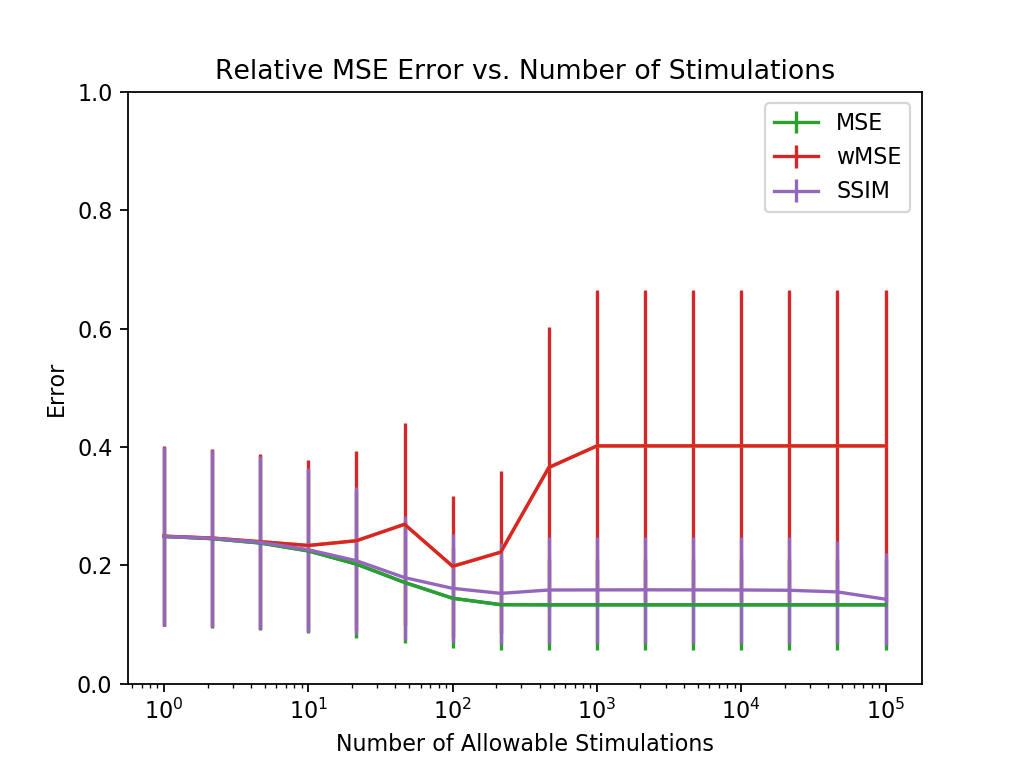

<IPython.core.display.Javascript object>


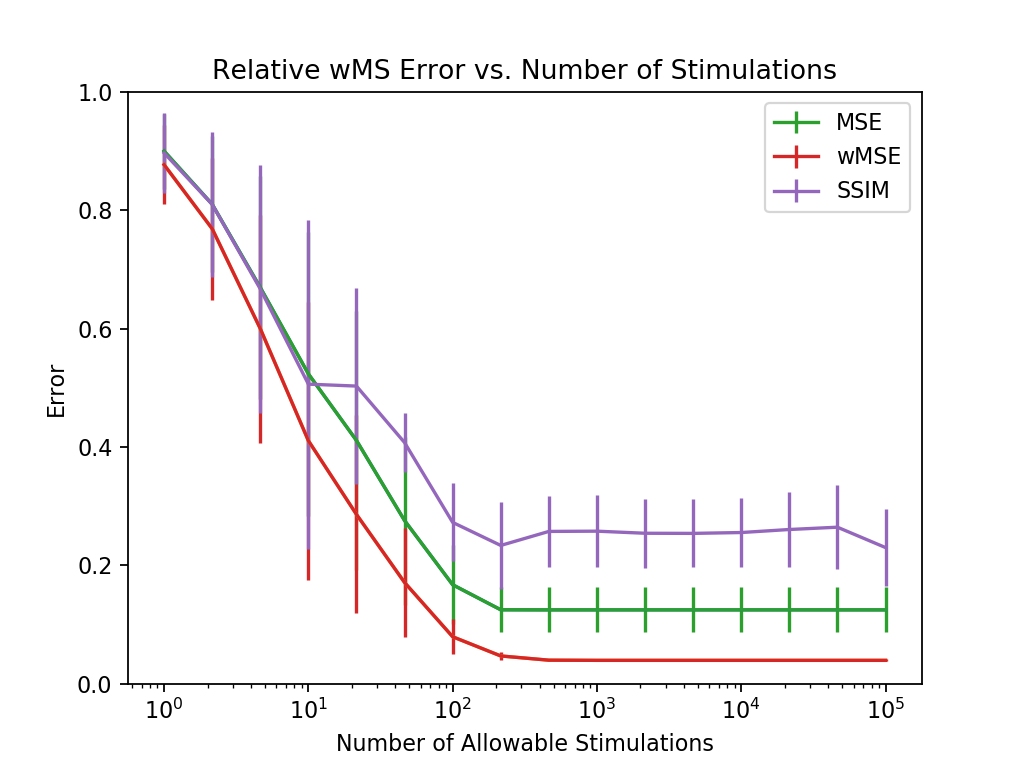

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:255: RuntimeWarning: divide by zero encountered in true_divide


<IPython.core.display.Javascript object>


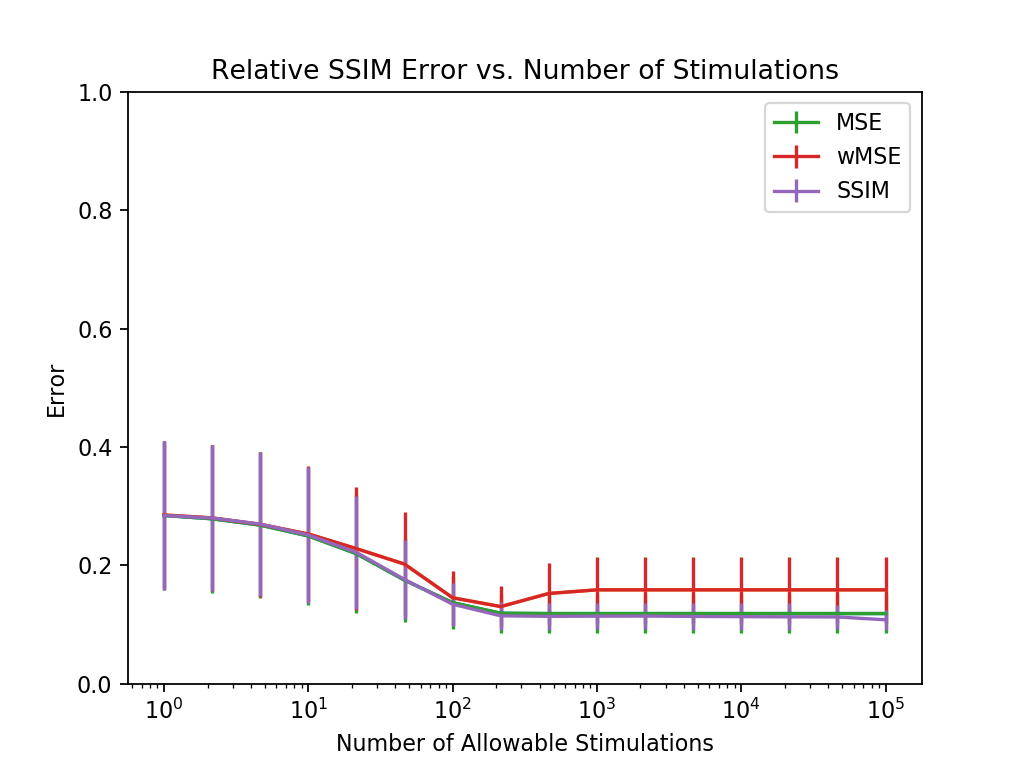

In [12]:
def plotStimCompar(imgData, ssData, metric, psychParams, pixelDims):
    # plot the error of given image sets versus number of stimulations according to  a specified metric, average over
    #  all images for each number of stimulations data point
    # Input: imgData: imgData object created by preProcessImage function
    #        metric: metric according to which activities 1 and 2 will be plotted/calculated: "mse", "wms", or "ssm"
    #        psychParams: a psychophysical parameters object 
    #        ssData: Stimulation Sweep Data output from numStimSweep Function
    #        pixelDims:  the dimensions of the unflattened image (e.g. (20, 20) )
    
    def getErr(refImg, img, metric,psychParams,pixelDims):
        # given two images, calculate the error according to the given metric
        # metric = "mse", "jpg", or "ssm"
        if metric.upper() == "MSE":
            return mse(refImg, img)/mse(refImg,np.zeros(refImg.shape))
        elif metric.upper() == "WMS" :
            return jpge(refImg, img, psychParams, pixelDims) / jpge(refImg, np.zeros(refImg.shape), psychParams, pixelDims)
        elif metric.upper() == "SSIM":
            return ((1-SSIM(refImg, img))/2) / ((1-SSIM(refImg,np.zeros(refImg.shape)/2)))
        else: 
            raise Exception("Bad Metric Passed to getErr")
    
    def getErrVecs(refImg, Ts, img1, img2, img3, metric, psychParams, pixelDims):
        # given single images generated over numStimPoints number of stimulations, return a numStimPointsx1 vector 
        # of error of each image according to the given metric
        # img1, img2, img3:  3 numPixels x numStimPoints matrices of activity(error is calculated over pixels)
        
        # Initialization
        errs1 = np.zeros((Ts.size,)) # Error Vector for set 1
        errs2 = np.zeros((Ts.size,)) # Error Vector for set 2
        errs3 = np.zeros((Ts.size,)) # Error Vector for set 3


        # caclulate the error of the first set of images, computing a numStimPoints vector of errors:
        for StimIdx in np.arange(Ts.size):
            errs1[StimIdx] = getErr(refImg,img1[:,StimIdx], metric, psychParams, pixelDims)
            errs2[StimIdx] = getErr(refImg,img2[:,StimIdx], metric, psychParams, pixelDims)
            errs3[StimIdx] = getErr(refImg,img3[:,StimIdx], metric, psychParams, pixelDims)
        
        return errs1, errs2, errs3
    
    # Initialization
    numImgs = imgData.numImgs
    Ts      = ssData.Ts
    errMat1 = np.zeros((numImgs,Ts.size))  # holds err vs stimulation vectors for numImgs, from imgSet 1
    errMat2 = np.zeros((numImgs,Ts.size))  # same for imgSet 2
    errMat3 = np.zeros((numImgs,Ts.size))  # same for imgSet 3

    
    # For each image i, generate the error vectors for imgs1, imgs2 and store in errMat1, errMat2
    for i in np.arange(numImgs):
        mseImgs = ssData.mseImgSet[:,:,i]
        wmsImgs = ssData.wmsImgSet[:,:,i]
        ssmImgs = ssData.ssmImgSet[:,:,i]
        refImg = imgData.imgSet[:,i]
        errMat1[i,:], errMat2[i,:], errMat3[i,:] = getErrVecs(refImg, Ts, mseImgs.T, wmsImgs.T, ssmImgs.T, metric, psychParams, pixelDims)

    avgs1 = np.mean(errMat1,0)
    stds1 = np.std(errMat1,0) / np.sqrt(numImgs)
    avgs2 = np.mean(errMat2,0)
    stds2 = np.std(errMat2,0) / np.sqrt(numImgs)
    avgs3 = np.mean(errMat3,0)
    stds3 = np.std(errMat3,0) / np.sqrt(numImgs)
    
    plt.semilogx(Ts,avgs1)
    plt.semilogx(Ts,avgs2)
    plt.errorbar(Ts,avgs1,yerr=stds1,label="MSE")
    plt.errorbar(Ts,avgs2,yerr=stds2,label="wMSE")
    plt.errorbar(Ts,avgs3,yerr=stds3,label="SSIM")

    plt.xlabel('Number of Allowable Stimulations')
    plt.ylabel("Error")
    string = "Relative " + metric + " Error vs. Number of Stimulations"
    plt.title(string)
    plt.ylim([0,1])
    plt.legend()

plt.figure()
plotStimCompar(imgData, stimSweepData, "MSE", psychParams, pixelDims)

plt.figure()
plotStimCompar(imgData, stimSweepData, "wMS", psychParams, pixelDims)

plt.figure()
plotStimCompar(imgData, stimSweepData, "SSIM", psychParams, pixelDims)


In [ ]:
#imgSet,xs,ys,zoomFac = preProcessImage(img,psychParams,simParams)
image = imgSet[:,980]
#image = imgSet[:,1420]
mseImg,mseActs = actSolver(image,simParams,psychParams,"mse",True)
jpgImg,jpgActs = actSolver(image,simParams,psychParams,"jpg",True)
ssmImg,ssmActs = actSolver(image,simParams,psychParams,"ssm",True)


plt.figure(figsize=(10,20))
plt.suptitle('MSE / CSF / SSIM Electrode Activity')
plt.subplot(311)
dispElecAct(mseActs,simParams)
plt.subplot(312)
dispElecAct(jpgActs,simParams)
plt.subplot(313)
dispElecAct(ssmActs,simParams)
#plt.savefig('elecActComp.jpg',bbox_inches='tight')
plt.show()

In [ ]:
#Old stuff goes here:
# def reconsMSE(img,simParams,electrode):
    
#     A = simParams["A"]
#     P = simParams["P"]
#     var = simParams["variance"]
    
#     mu = np.mean(img)
#     imgCopy = copy.deepcopy(img)
#     imgCopy -= mu
#     if electrode:
#         if not var:
#             xMSE = nnls(A@P,imgCopy)[0]
#         else:
#             V = np.zeros(P.shape)
#             for j in np.arange(P.shape[1]):
#                 V[:,j] = np.multiply(P[:,j],(1-P[:,j]))
#             varMtx =  np.multiply(A,A)@V
#             stackedA = np.vstack((A@P,varMtx))
#             stackedB = np.zeros((imgCopy.shape[0]*2,))
#             stackedB[0:imgCopy.shape[0]] = imgCopy
#             xMSE = nnls(stackedA,stackedB)[0]
#         return A@P@xMSE+mu, xMSE

#     else: 
#         xMSE = nnls(A,imgCopy)[0]    
#         return A@xMSE+mu, xMSE

# def reconsJPG(img,simParams,psychParams,electrode):
#     # Given a subimage subImg, and a decoder matrix A, as well as psychpysical params ppd and pf,
#     # compute the optimally reconstructed image according to the SFE metric and return it as a vector
#     #argmin || WD(S - APx) ||= || WDS - WDAP x ||
#     W = flatW(psychParams,simParams["pixelDims"])
#     D = flatDCT(pixelDims)
#     S = copy.deepcopy(img)
#     muS = np.mean(S)
#     S -= muS
    
#     A = simParams["A"]
#     P = simParams["P"]
#     var = simParams["variance"]
    
#     if electrode:
#         if not var:
#             xSF = nnls(W@D@A@P,W@D@S)[0]
#         else:
#             V = np.zeros(P.shape)
#             for j in np.arange(P.shape[1]):
#                 V[:,j] = np.multiply(P[:,j],(1-P[:,j]))
#             varMtx = np.multiply(W@D@A,W@D@A)@V
#             Atilde = W@D@A@P
#             stackedA = np.vstack((Atilde,varMtx))
#             stackedA[0:Atilde.shape[0],:] = Atilde
#             stackedB = np.zeros((S.size*2,))
#             stackedB[0:S.size] = W@D@S
#             xSF = nnls(stackedA,stackedB)[0]    
#         return A@P@xSF+muS,xSF
    
#     else: 
#         xSF = nnls(W@D@A,W@D@S)[0]
#         return A@xSF+muS,xSF